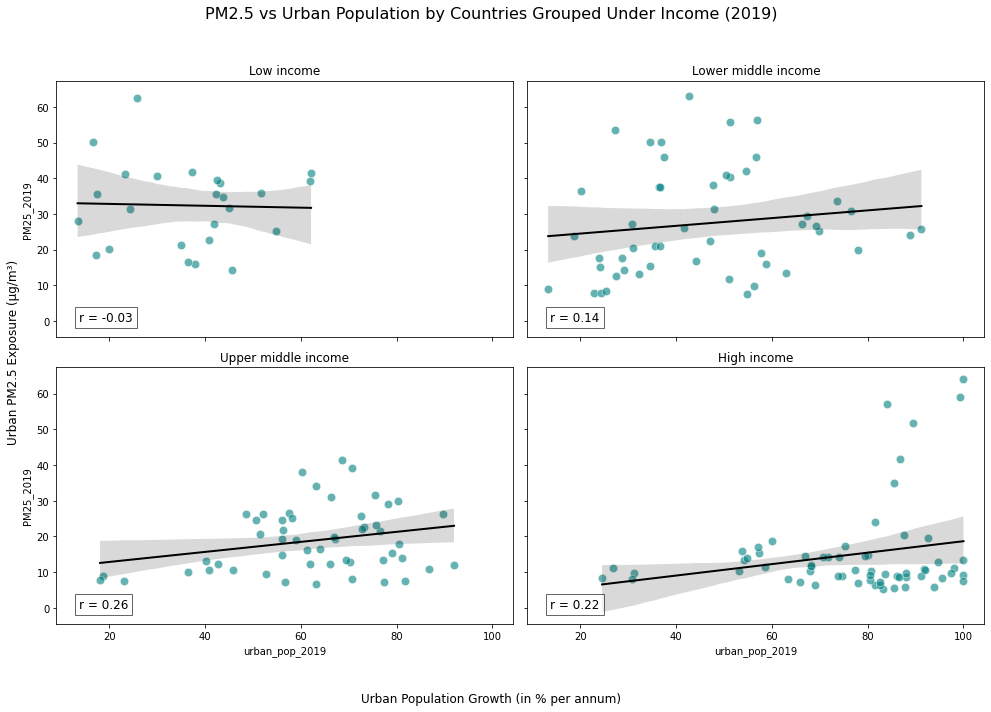

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import pearsonr

# Exposure to particulate matter: A population weighted mean annual concentration of fine suspended particles of less than 2.5 microns in diameter for urban population in a country
airp= pd.read_csv("assets/pm25-air-p1.csv")
# concentration of particulate matter 2.5 (PM2.5) for the year 2019
airp_2019 = airp[airp['Year']==2019]
airp_2019 = airp_2019[['Code','Year','Concentrations of fine particulate matter (PM2.5) - Residence area type: Total']].copy()
airp_2019 = airp_2019.rename(columns={'Code':'country_code', 'Concentrations of fine particulate matter (PM2.5) - Residence area type: Total': 'PM25_2019'})
airp_2019 = airp_2019.dropna()


#Urban population growth in a country (% per annum)
urban = pd.read_csv("assets/Urban_popultion.csv")
urban.columns = urban.columns.map(lambda x: x.split(' ')[0] if 'YR' in x else x)
urban = urban[['Country Name', 'Country Code', '2010', '2011', '2012', '2013', '2014','2015', '2016', '2017', '2018', '2019']].copy()
urban = urban.dropna()
#Urban population growth for every country in the world for the year 2019
urban_2019 = urban[['Country Name','Country Code', '2019']].copy()
urban_2019 = urban_2019.rename(columns={'Country Code':'country_code', '2019':'urban_pop_2019', 'Country Name':'country_name'})

# classification of countries on income
income = pd.read_csv("assets/Metadata_Country_API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_22447.csv")
income_filtered = income[['Country Code','IncomeGroup']].copy()
income_filtered = income_filtered.dropna(subset=['IncomeGroup'])
income_filtered = income_filtered.rename(columns={'Country Code':'country_code', 'IncomeGroup':'income_group'})

# merged dataframe
merge_df_2019 = airp_2019.merge(urban_2019, on='country_code').merge(income_filtered, on = 'country_code')
#filter and cleaning
merge_df_2019.dropna(inplace=True)
merge_df_2019['urban_pop_2019'] = pd.to_numeric(merge_df_2019['urban_pop_2019'], errors='coerce')
merge_df_2019['PM25_2019'] = pd.to_numeric(merge_df_2019['PM25_2019'], errors='coerce')
merge_df_2019 = merge_df_2019.dropna(subset=['urban_pop_2019', 'PM25_2019'])

#plot
fig, axes =plt.subplots(2,2, figsize = (14, 10), sharex = True, sharey = True)
fig.suptitle('PM2.5 vs Urban Population by Countries Grouped Under Income (2019)', fontsize = 16)

income_group =['Low income', 'Lower middle income', 'Upper middle income', 'High income']
axes = axes.flatten()

for i, group in enumerate(income_group):
    ax = axes[i]
    #grouping countries based on income class
    group_df = merge_df_2019[merge_df_2019['income_group'] == group].copy()

    #scatter plot
    sns.scatterplot(data = group_df, 
                    x = 'urban_pop_2019',
                    y = 'PM25_2019',
                    ax= ax,
                    color = 'teal',
                    alpha= 0.6,
                    s = 70)
    #regression line
    sns.regplot(data = group_df,
                x = 'urban_pop_2019',
                y = 'PM25_2019',
                scatter = False,
                color='black',
                line_kws={'linewidth':2},
               ax=ax)
    #computing and annotate Pearson correlation
    if len(group_df)>=2:
        r,p = pearsonr(group_df['urban_pop_2019'], group_df['PM25_2019'])
        ax.text(0.05,0.05, f'r = {r:.2f}', transform=ax.transAxes,
                fontsize=12, verticalalignment = 'bottom',horizontalalignment='left', bbox = dict(facecolor='white', alpha=0.6))

    #labeling top 3 polluters with the highest PM2.5 in each group
    #top_polluters = group_df.nlargest(3, 'PM25_2019')
    #for _, row in top_polluters.iterrows():
        #ax.text(row['urban_pop_2019'], row ['PM25_2019'], row['country_name'],
                #fontsize = 9, ha='left', va='top')
    ax.set_title(group)

fig.supxlabel('Urban Population Growth (in % per annum)', fontsize=12)
fig.supylabel ('Urban PM2.5 Exposure (µg/m³)', fontsize=12)
                

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('urban_pop_vs_air_pollution1.jpg')
plt.show()                